## For Matching buzzard halos with redMaPPer clusters. 
### Created Jan, 2018
### Zhuowen Zhang

**Update April 29, 2018:** 

Halo files are halos_unique in Buzzard Y3 to get rid of overlapping halos in boxes with overlapping regions. Mass definition is M200b. Cosmology used for comoving distance measurements reflect 
Buzzard cosmology. 

**Update April 25, 2019:** 

1. Use the Chinchilla-0_halos_unique_all.fits which combines all *_unique_X FITs files, so that no need to merge files for each run. Saves time. 


2. Change of halo matching algorithm. For some clusters halos and cluster centers have exact match, when both are centerd on the BCG. The algo now only applies mass-richness priority matcihng to none (RA,DEC,Z) matched cluster/halos. This should reduce the number of miscentering from ~50% of 20,000 redM halos to something more like the real data, refer Y.Zhang et al 2019. 


In [47]:
import numpy as np
import sys
#sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from tools.setup.setup import home_dir
home_dir = home_dir()

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()

# setup notebook for inline figures
%matplotlib inline

In [48]:
#Convert from z to comoving distance in fiducial cosmology
from astropy import units as u
from astropy import cosmology
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

In [49]:
from tools.setup.setup import *
import astropy.io.fits as fits
#Read http://pythonhosted.org/pyfits/

datadir = data_home_dir()
bigdatadir = bigdata_home_dir()

### Extracting Halo and Cluster Files
From buzzard and Chinchilla in Slac_Stanford simulation repository

In [63]:
bigdatadir = bigdata_home_dir()
print bigdatadir
redM_data = bigdatadir+'Buzzard_Sims/v1.9.2/Chinchilla-4/redMaPPer/'+'buzzard-4_1.9.2+allruns_redmapper_v6.4.22_lgt20_vl02_catalog.fit'
redM_list = fits.open(redM_data)
redM_data = redM_list[1].data

print "Names of columns in redM_data are: \n"
print redM_data.names

print "Number of clusters is ", len(redM_data)
print "Lambda cut is ", min(redM_data.LAMBDA_CHISQ)

/data/DES/Cluster/
Names of columns in redM_data are: 

['MEM_MATCH_ID', 'RA', 'DEC', 'MODEL_MAG', 'MODEL_MAGERR', 'REFMAG', 'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ', 'BCG_SPEC_Z', 'Z_SPEC_INIT', 'Z_INIT', 'Z', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'R_LAMBDA', 'SCALEVAL', 'MASKFRAC', 'GEOMASKFRAC', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'CHISQ', 'Z_LAMBDA', 'Z_LAMBDA_E', 'Z_LAMBDA_NITER', 'EBV_MEAN', 'LNLAMLIKE', 'LNBCGLIKE', 'LNLIKE', 'PZBINS', 'PZ', 'NCROSS', 'RMASK', 'RA_ORIG', 'DEC_ORIG', 'W', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'LAMBDA_CHISQ_C', 'LAMBDA_CHISQ_CE', 'NCENT', 'NCENT_GOOD', 'RA_CENT', 'DEC_CENT', 'ID_CENT', 'LAMBDA_CHISQ_CENT', 'ZLAMBDA_CENT', 'P_BCG', 'P_CEN', 'Q_CEN', 'P_FG', 'Q_MISS', 'P_SAT', 'P_C', 'BCG_ILUM', 'ILUM', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD', 'MASKGAL_INDEX']
Number of clusters is  8886
Lambda cut is  19.8967


### Halo file after BCG and hosthalo cut

In [82]:
#Only record array pickle file
import pickle
halo_file = bigdatadir + 'Buzzard_Sims/v1.9.2/Chinchilla-4/halos/' + 'halos_BCG_hosthalo_cut_v1.9.2_Chinchilla_4.data'
halo_file = open(halo_file, "rb" )
halos_data = pickle.load(halo_file)

#Checking FITS into
#hrun_list.info()
print "Names of columns in halos_data are: \n"
print halos_data.dtype

#Converting FITS files into record array
halos_data = np.array(halos_data, dtype=halos_data.dtype)
halos_data = halos_data.view(np.recarray)

print "\n Number of halos is", len(halos_data.ID)

Names of columns in halos_data are: 

(numpy.record, [('A[Z]', '>f8'), ('A[Y]', '>f8'), ('RA', '>f8'), ('C[Y]', '>f8'), ('VMAX', '>f8'), ('C_TO_A', '>f8'), ('Z', '>f8'), ('Z_COS', '>f8'), ('JX', '>f8'), ('B[Z]', '>f8'), ('TRA', '>f8'), ('VZ', '>f8'), ('B[X]', '>f8'), ('VY', '>f8'), ('HOST_HALOID', '>i8'), ('M200C', '>f8'), ('B[Y]', '>f8'), ('VX', '>f8'), ('JZ', '>f8'), ('A[X]', '>f8'), ('VRMS', '>f8'), ('M200B', '>f8'), ('M500C', '>f8'), ('TDEC', '>f8'), ('RS', '>f8'), ('C[Z]', '>f8'), ('ID', '>i8'), ('SPIN', '>f8'), ('VOFF', '>f8'), ('NP', '>f8'), ('PY', '>f8'), ('RVIR', '>f8'), ('M2500C', '>f8'), ('DEC', '>f8'), ('MVIR', '>f8'), ('C[X]', '>f8'), ('PZ', '>f8'), ('JY', '>f8'), ('XOFF', '>f8'), ('PX', '>f8'), ('B_TO_A', '>f8')])

 Number of halos is 3109744


### Cuts and filters
#### Mass cut

mcut_val = 1e13
mass_cutoff = halos_data['M200B'] > mcut_val
halos_data = halos_data[mass_cutoff]
print "After mass cut of M > {} M_sun number of halos is ".format(mcut_val), len(halos_data)

## Extract Parameters from Files
Note that RA, DEC are in radians, unusal way of expressing them.

In [84]:
#Parameters for matching
redM_ID = redM_data['MEM_MATCH_ID']
#Convert to radians to match halos
redM_RA = redM_data['RA']; redM_DEC = redM_data['DEC']
redM_z = redM_data['Z_LAMBDA']
redM_lmda = redM_data['LAMBDA_CHISQ']; 

halos_ID = halos_data['ID']; 
halos_RA = halos_data['RA']; halos_DEC = halos_data['DEC']; 
halos_z = halos_data['Z']

halos_M200b = halos_data['M200B']; halos_Mvir = halos_data['MVIR']

halos_Rvir = halos_data['RVIR'] #in kpc
halos_X = halos_data['PX']; halos_Y = halos_data['PY']; halos_Z = halos_data['PZ']

## Rotate the halo files

**Update April 26, 2019** 

Chunhao uses np.dot(rmat.T, halos_posvec), or the transpose of that if you make halos_posvec a Nx3 matrix.

It should however be np.dot(rmat, halos_posvec), no transpose.

Rotation not needed if using the halo run observed coordinates. 

In [85]:
# Rotate the halo files
import healpy as hp
import fitsio
from tools.setup.setup import tools_home_dir
import pickle

toolsdir = tools_home_dir()

#file containing the rotation matrix 
rotfile = toolsdir+'desy3_irot.pkl'

with open(rotfile, 'r') as fp:
    rmat = pickle.load(fp)
    
#This is done with the true coordinates.
#halos_norm = np.sqrt(halos_data['PX']**2. + halos_data['PY']**2. + halos_data['PZ']**2. )    
#halos_posvec = np.array([halos_data['PX'], halos_data['PY'], halos_data['PZ']])/halos_norm

#Need to convert from ang to vec.
theta = np.pi/2 - halos_DEC*np.pi/180.
phi = halos_RA*np.pi/180
halos_posvec = hp.ang2vec(theta, phi).T

#Rotation
halos_rposvec = np.matmul(rmat, halos_posvec)

#Rotate the Cartesian positions.
#halos_X = halos_rposvec[0]*halos_norm; halos_Y = halos_rposvec[1]*halos_norm; halos_Z = halos_rposvec[2]*halos_norm

#convert to angular coords (in degrees)
theta2, phi2 = hp.vec2ang(halos_rposvec.T)
halos_DEC = (np.pi/2 - theta2) * 180/np.pi
halos_RA = phi2 * 180/np.pi

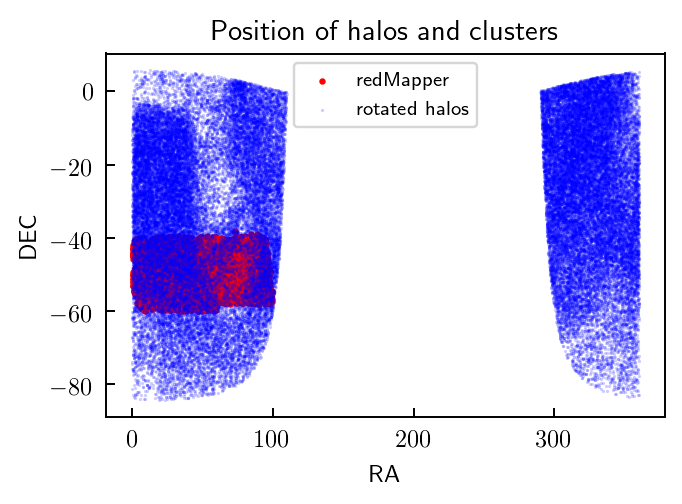

In [86]:
#Scatter plot to inspect that halos match clusters
plt.figure(figsize=(4,3))
plt.scatter(redM_RA, redM_DEC, c='r', s=7, marker='o',linewidth=0.0, label='redMapper')
plt.scatter(halos_RA[::50], halos_DEC[::50], c='b', marker='.', s=7, linewidth=0.0, alpha=0.2, label='rotated halos')

plt.xlabel('RA'); plt.ylabel('DEC ')
plt.legend(fontsize=8, loc='upper center')
plt.title('Position of halos and clusters')
plt.tight_layout()
#plt.savefig('halo_cluster_pos.png')
plt.show()

## Finding miscentered clusters 

For those with (RA,DEC) targeted on the same BCG automatically assumes as centered. The rest are miscentered and the halo-cluster matching applies to those. 

Note that halos are initially unrotated and redM rotated, so this should come after rotation algo. 

### Testing: find least angular separation of halos with redM, using single redM clusters. 

In [90]:
#Finding mismatch between RA, DEC, Z in halorun versus redM_galaxy
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

#Using find_nearest iterate through the array and find index of matched ones, also index of unmatched. 
#Go through the richness-mass template finder. 
redM_coord = SkyCoord(redM_data.RA*u.deg, redM_data.DEC*u.deg,  frame='icrs')
halos_coord = SkyCoord(halos_RA*u.deg, halos_DEC*u.deg, frame='icrs')

#Finding nearest neighbor to the halorun catalog.
def find_nearest(ind):
    dist_sep = halos_coord.separation(redM_coord[ind])
    idx = (np.abs(dist_sep)).argmin()
    return idx, dist_sep[idx].value

#Testing match of specific halo using index testn
testarr = np.arange(0,1000,100)
for i, testn in enumerate(testarr):
    ind, dist = find_nearest(testn)
    print "redM index: ", testn
    print "Halo matched index:", ind
    print "Total angular separation: ", dist
    print "RA difference: ", halos_RA[ind] -  redM_RA[testn]
    print "DEC difference: ", halos_DEC[ind] - redM_data.DEC[testn]
    #print hrun_data.Z[testn] - redM_gal_data.Z[ind] #Some error in redshift
    print "Redshift difference: {:2g} \n".format(redM_data.Z[testn] - halos_data.Z[ind]) #Small error in redshift

redM index:  0
Halo matched index: 2855463
Total angular separation:  0.0707904848064
RA difference:  -0.03715632510990474
DEC difference:  0.0664440195875926
Redshift difference: -0.467266 

redM index:  100
Halo matched index: 2862563
Total angular separation:  0.0592608806875
RA difference:  -0.03602085262791377
DEC difference:  0.05483732938129293
Redshift difference: -0.602643 

redM index:  200
Halo matched index: 2299995
Total angular separation:  0.0155020320221
RA difference:  0.029463258601637676
DEC difference:  -0.0005247265642012167
Redshift difference: -0.265165 

redM index:  300
Halo matched index: 2687477
Total angular separation:  0.0368972612823
RA difference:  0.06894018624207376
DEC difference:  -0.002525111249887857
Redshift difference: -0.00513718 

redM index:  400
Halo matched index: 2724107
Total angular separation:  0.011548735766
RA difference:  0.015997242807685552
DEC difference:  0.006608655938102004
Redshift difference: -0.46409 

redM index:  500
Halo m

#### Running miscentering code for all clusters
The SkyCoord coordinate matching algo takes some time to run. Few hours. 

In [40]:
#Finding redM's nearest halo neighbor.
def find_nearest(ind):
    dist_sep = halos_coord.separation(redM_coord[ind])
    idx = (np.abs(dist_sep)).argmin()
    return idx, dist_sep[idx].value

centered_ID = [] #for clusters
cent_halo_ID = []

#Find the centered ones
ang_lim = 1e-5
z_lim = 0.01
redM_coord = SkyCoord(redM_data.RA*u.deg, redM_data.DEC*u.deg,  frame='icrs')
halos_coord = SkyCoord(halos_RA*u.deg, halos_DEC*u.deg, frame='icrs')

for i, cur_cl in enumerate(redM_data):
    cur_ID = cur_cl['MEM_MATCH_ID']
    cur_RA = cur_cl['RA']
    cur_DEC = cur_cl['DEC']
    ind, ang_sep = find_nearest(i)
    z_sep = np.abs(cur_cl['Z_LAMBDA'] - halos_z[ind])

    #ind = np.argmin(np.abs(cur_RA-halos_RA)) #this speeds up the calculation, asssuming minRA gives min_distance
    
    halo_ID = halos_ID[ind]
    RA_val = halos_RA[ind]
    DEC_val = halos_DEC[ind]
    #ang_sep = np.sqrt((RA_val-cur_RA)**2 + (DEC_val-cur_DEC)**2)

    if (ang_sep <= ang_lim) & (z_sep <= z_lim): 
        centered_ID.append(cur_ID)
        cent_halo_ID.append(halo_ID)
        
    if i % 10 == 0: 
        print "Processing cluster number ", i
        print "Number of centered are", len(centered_ID)
print "Total number of centered clusters are", len(centered_ID)
print "Out of total number of clusters of ", len(redM_data)

Processing cluster number  0
Number of centered are 0
Processing cluster number  10
Number of centered are 0
Processing cluster number  20
Number of centered are 0
Processing cluster number  30
Number of centered are 0
Processing cluster number  40
Number of centered are 0
Processing cluster number  50
Number of centered are 0
Processing cluster number  60
Number of centered are 0
Processing cluster number  70
Number of centered are 0
Processing cluster number  80
Number of centered are 0
Processing cluster number  90
Number of centered are 0
Processing cluster number  100
Number of centered are 0


KeyboardInterrupt: 

In [ ]:
from scipy.spatial import cKDTree
#Arrays of halos and clusters are one to one matched.
#Matching clusters
cent_ind = [i for i, x in enumerate(redM_data.MEM_MATCH_ID) if x in centered_ID]
miscent_ind = [i for i, x in enumerate(redM_data.MEM_MATCH_ID) if x not in centered_ID]
redM_cent = redM_data[cent_ind]
redM_miscent = redM_data[miscent_ind]

print "Number of centered clusters are ", len(redM_cent)
print "Number of miscentered clusters are ", len(redM_miscent)
print "Total number of clusters are", len(redM_data)

##For finding halos
#mytree.query is much faster than enumerate for 1e6 halos
HALOID_2d = np.dstack([halos_data['HALOID'],halos_data['HALOID']])[0]  # needs to be 2D arrays
mytree = cKDTree(HALOID_2d)  
dist, cent_ind = mytree.query(np.dstack([cent_halo_ID,cent_halo_ID])[0])
miscent_ind = np.delete(range(len(halos_data)), cent_ind)
halos_cent = halos_data[cent_ind]
halos_miscent = halos_data[miscent_ind]

print "\nNumber of centered halos are ", len(halos_cent)
print "Number of miscentered halos are ", len(halos_miscent)
print "Total number of halos are", len(halos_data)

## Diagnosis plots for centered halos

#### Mass distribution

In [ ]:
m_range = (1e13, 1e15)
#plt.hist(halos_data.M200B, 1000, m_range, density=True, alpha=0.5)
plt.hist(halos_cent.M200B, 1000, m_range, density=True, alpha=0.5)
plt.xscale('log')
plt.show()

#### Redshift distribution. Introduce a cutoff at z < 0.01

In [ ]:
#Plot the redshift difference of halos and redM
z_diff = redM_cent.Z_LAMBDA - halos_cent.Z
plt.scatter(halos_cent.M200B, z_diff, s=0.5)
plt.ylabel('z diff')
plt.xlabel('Mass')
#plt.ylim([-0.1,0.1])
plt.xscale('log')
plt.show()

#### Angular separation. Introduce cutoff at deg < 1e-5

In [ ]:
ang_sep = np.sqrt((halos_cent.RA_OBS-redM_cent.RA)**2 + (halos_cent.DEC_OBS-redM_cent.DEC)**2)
print np.min(ang_sep), np.max(ang_sep), np.mean(ang_sep), np.median(ang_sep)
plt.scatter(halos_cent.M200B, ang_sep, s=0.5)
plt.xscale('log')
plt.ylim([-1e-6,1e-5])
plt.show()

#### Lambda-mass relation. The lambda cutoff may be reason for the sharp mass cutoff.

In [ ]:
#Plot the lambda mass relation 
plt.scatter(halos_cent.M200B, redM_cent.LAMBDA_CHISQ, s=0.5)
plt.xscale('log')
plt.show()

## Randomly select halos

import os
print os.getcwd()
print os.path.exists('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster/output')

import numpy.random as rand

#First apply a redshift cut, and then randomly select in that redshift. 
halos_cut = np.where((halos_data['Z']<0.90) & (halos_data['M200b'] > 1e13))
halos_rand = halos_data[halos_cut]

#Select 100,000 random samples
num_rand = 10000
rand_samp = rand.randint(0,len(halos_rand), num_rand)
halos_rand = halos_rand[rand_samp]

#Retreive columns
halos_rand_ID = halos_rand['ID']; halos_rand_RA = halos_rand['RA'] 
halos_rand_DEC = halos_rand['DEC']; halos_rand_z = halos_rand['Z']

halos_rand_M200b = halos_rand['M200b']; halos_rand_Mvir = halos_rand['MVIR']

halos_rand_Rvir = halos_rand['RVIR'] #in kpc
halos_rand_X = halos_rand['PX']; halos_rand_Y = halos_rand['PY']; halos_rand_Z = halos_rand['PZ']

#Need to convert Radius to MPC for units to work in the read_halo_particle code
halos_rand_Rvir /= 1000

#### Writing to file
For improvement, this code should check if file exists. If so write a new file. 

## IDs from the Projection Catalog
IDs from the projection catalog as found through proximity matching to the buzzard catalog. 

## Halo and cluster matching algorithm
All centered clusters are automatically assigned a halo. Algorithm applies to miscentered clusters. 

**Important** RA, DEC need to be in radians for the matching to work. Create new array in RA, DEC. Does not change old ones. 

In [ ]:
#Extract parameters again, but only for miscentered ones. 

#Parameters for matching
redM_ID = redM_miscent['MEM_MATCH_ID']
#Convert to radians to match halos
redM_RA = redM_miscent['RA'] * np.pi/180; redM_DEC = redM_miscent['DEC'] * np.pi/180
redM_z = redM_miscent['Z_LAMBDA']
redM_lmda = redM_miscent['LAMBDA_CHISQ']; 

halos_ID = halos_miscent['HALOID']; 

##The RA, DEC have to be in radians for trig distance finder to output correct results!!
halos_RA = halos_miscent['RA_OBS'] * np.pi/180; halos_DEC = halos_miscent['DEC_OBS'] * np.pi/180; 
halos_z = halos_miscent['Z']

halos_M200b = halos_miscent['M200B']; halos_Mvir = halos_miscent['MVIR']

halos_Rvir = halos_data['RVIR'] #in kpc
halos_X = halos_miscent['PX']; halos_Y = halos_miscent['PY']; halos_Z = halos_miscent['PZ']

##Extract distance.
redM_comvr = cosmo.comoving_distance(redM_miscent.Z).value
halos_comvr = cosmo.comoving_distance(halos_miscent.Z).value

In [ ]:
plt.scatter(halos_RA[::100], halos_DEC[::100], s=0.1)
plt.scatter(redM_RA, redM_DEC, s=0.1)
plt.show()

In [ ]:
#Cluster matching algorithm: Go down list of halos, 
#from most to least massive, and find potential cluster matches

#Find sorted indices for halos_M
halos_sort=np.asarray(sorted(range(len(halos_M200b)),key=lambda x:halos_M200b[x],reverse=True))
print "Number of halos is ", halos_sort.shape[0]

#Build SkyCoord distance
redM_coord = SkyCoord(redM_data.RA*u.deg, redM_data.DEC*u.deg,  frame='icrs')
halos_coord = SkyCoord(halos_RA*u.deg, halos_DEC*u.deg, frame='icrs')


cl_match_ind = np.array([]) #indices of (potentially) matched clusters 
cl_uniq_ind = np.array([]) #unique indices to select uniquely matched clusters
for i in range(halos_sort.shape[0]):
    cur_halo_RA = halos_RA[halos_sort[i]]; cur_halo_DEC = halos_DEC[halos_sort[i]]
    cur_halo_comvr = halos_comvr[halos_sort[i]]; cur_halo_z = halos_z[halos_sort[i]]
    
    #Assume clusters that fall into this redshift range have the same redshift as the halo. 
    #Find the distance to the halo according to this assumption, and find ones local to the halo.
    
    #Find clusters within redshift bin of +/- 0.01
    zbin = 0.01
    zbin_cl_ind = np.asarray(np.where(np.abs(cur_halo_z-redM_z)<zbin)[0])
    
    #Filter clusters in redshift proximity region
    redM_DEC_zfilt = redM_DEC[zbin_cl_ind]; redM_RA_zfilt = redM_RA[zbin_cl_ind]
    
    #Angle difference from RA, DEC using spherical law of cosines
    d_lmda = redM_RA_zfilt - cur_halo_RA
    d_Sigma = np.arccos(np.sin(redM_DEC_zfilt)*np.sin(cur_halo_DEC)+\
                        np.cos(redM_DEC_zfilt)*np.cos(cur_halo_DEC)*np.cos(d_lmda))
    
    #comoving distance between halo and clusters from law of cosines for clusters in same comoving distance,
    #using the halos's redshift
    d_cmvr = np.sqrt(2*cur_halo_comvr**2.*(1.-np.cos(d_Sigma)))
    
    #find eligible local clusters based on proxmity, and remove repeat cluster already taken by higher mass halos
    max_d_cmvr = 1.0 #set to 2Mpc
    loc_cl_ind = zbin_cl_ind[np.where(d_cmvr<max_d_cmvr)]
    loc_cl_ind = np.setdiff1d(loc_cl_ind, cl_uniq_ind) #remove clusters already taken by higher mass halos
    
    #if local clusters present find richest one
    if np.size(loc_cl_ind) > 0:
        cur_cl_match_ind = loc_cl_ind[np.argmax(redM_lmda[loc_cl_ind])]
        cl_uniq_ind= np.append(cl_uniq_ind, cur_cl_match_ind)
    else:
        cur_cl_match_ind = -1 #-1 for no match
        
    cl_match_ind = np.concatenate((cl_match_ind, [cur_cl_match_ind]))
    
    if i%1e5 == 0:
        print "\nMatching halo number ", i
        print "Number of clusters in redshift bin is ", np.shape(zbin_cl_ind)
        print "Number of local clusters in distance range is ", np.shape(loc_cl_ind)  
        print 'Number of clusters matched to halos are ', np.shape(np.where(cl_match_ind>-1))[1]
        #print 'cl_match indices are ', np.where(cl_match_ind > -1)
        #print 'd_cmvr ', d_cmvr[0:50]
        #print 'zbin_cl_ind is ', zbin_cl_ind
        
        #Check for duplicates
        #print 'Unique clusters indices are', cl_uniq_ind
        #dupes = [x for n, x in enumerate(cl_uniq_ind) if x in cl_uniq_ind[:n]]
        #print 'Duplicate clusters are ', dupes # [[1], [3]]

print 'Number of clusters matched to halos are ', np.shape(np.where(cl_match_ind>-1))[1]


In [ ]:
#Sample test of mass richness using matched clusters only
halos_match_ind = np.where(cl_match_ind != -1)
halos_M200b_match = halos_M200b[halos_sort[halos_match_ind]]
#print halos_match_ind
redM_lmda_match = redM_lmda[np.asarray(cl_match_ind[halos_match_ind],dtype=int)]
plt.plot(halos_M200b_match, redM_lmda_match, '.', alpha=0.5)
plt.xscale('log')
plt.title('Halo-Cluster (match halos onto clusters only)')
#plt.ylabel(r'Richness (\lambda)'); plt.xlabel(r'Mass (M_\odot)')
#plt.tight_layout()
#plt.savefig('Halo_Cluster_clmatch_only.png')
plt.show()


In [ ]:
#Halo matching algorithm: Go down list of redMapper clusters and find potential halo matches
#Repeat the same process for clusters. 
#Test and debug code. 

redM_sort=np.asarray(sorted(range(len(redM_lmda)),key=lambda x:redM_lmda[x],reverse=True))
print 'Number of redMapper clusters are ', len(redM_sort)
halos_match_ind = np.array([]) #indices of (potentially) matched halos 
halos_uniq_ind = np.array([])
for i in range(redM_miscent.shape[0]):
    cur_cl_RA = redM_RA[redM_sort[i]]; cur_cl_DEC = redM_DEC[redM_sort[i]]
    cur_cl_comvr = redM_comvr[redM_sort[i]]; cur_cl_z = redM_z[redM_sort[i]]
    
    #Assume clusters that fall into this redshift range have the same redshift as the halo. 
    #Find the distance to the halo according to this assumption, and find ones local to the halo.
    
    #Find clusters within redshift bin of +/- 0.05 
    zbin = 0.05
    zbin_halos_ind = np.asarray(np.where(np.abs(halos_z-cur_cl_z)<zbin))
    
    #Filter clusters in redshift proximity region
    halos_DEC_zfilt = halos_DEC[zbin_halos_ind]; halos_RA_zfilt = halos_RA[zbin_halos_ind]
    
    #Angle difference from RA, DEC using spherical law of cosines
    d_lmda = halos_RA_zfilt - cur_cl_RA
    d_Sigma = np.arccos(np.sin(halos_DEC_zfilt)*np.sin(cur_cl_DEC)+\
                        np.cos(halos_DEC_zfilt)*np.cos(cur_cl_DEC)*np.cos(d_lmda))
    
    #comoving distance between halo and clusters from law of cosines for clusters in same comoving distance
    d_cmvr = np.sqrt(2*cur_cl_comvr**2.*(1.-np.cos(d_Sigma)))
    
    #find local clusters
    max_d_cmvr = 2.0 #set to 1Mpc
    loc_halos_ind = zbin_halos_ind[np.where(d_cmvr<max_d_cmvr)]
    loc_halos_ind = np.setdiff1d(loc_halos_ind, halos_uniq_ind) #remove halos taken by richer clusters
    
    #if local halos present find most massive one
    if np.size(loc_halos_ind) > 0:
        cur_halos_match_ind = loc_halos_ind[np.argmax(halos_M200b[loc_halos_ind])]
        halos_uniq_ind = np.append(halos_uniq_ind, cur_halos_match_ind)
    else:
        cur_halos_match_ind = -1 #-1 for no match
        
    halos_match_ind = np.concatenate((halos_match_ind, [cur_halos_match_ind]))
    
    if i%1e3 == 0:
        print "Matching cluster number ", i
        #print 'Halo_match indices are ', np.where(halos_match_ind > -1)
                              
        #Check for duplicates
        #print 'Unique halo indices are', halos_uniq_ind
        #dupes = [x for n, x in enumerate(cl_uniq_ind) if x in cl_uniq_ind[:n]]
        #print 'Duplicate clusters are ', dupes # [[1], [3]]

print 'Number of halos matched to clusters are ', np.shape(np.where(halos_match_ind>-1))[1]                    

In [ ]:
clusters_match_ind = np.where(halos_match_ind != -1)
redM_lmda_match = redM_lmda[redM_sort[clusters_match_ind]]
#print halos_match_ind
halos_M200_match = halos_M200b[np.asarray(halos_match_ind[clusters_match_ind],dtype=int)]

print np.shape(halos_M200_match), np.shape(redM_lmda_match)
plt.plot(halos_M200_match, redM_lmda_match, '.', alpha=0.5)
plt.xscale('log')
plt.title('Halo-Cluster (match clusters onto halos only)')
plt.ylabel(r'Richness ($\lambda$)'); plt.xlabel(r'Mass ($M_\odot$)')
plt.tight_layout()
#plt.savefig('Halo_Cluster_halosmatch_only.png')
plt.show()

### Debugging


In [ ]:
#Check that in cl_match_ind the clusters matched to halos are physically adjacent. Check for redshift.
print "Check for cl_match_ind matching "
cl_match_ind_full = np.where(cl_match_ind != -1)
cl_zfilt = np.asarray(cl_match_ind[cl_match_ind_full], dtype=int)
halos_z_sorted = np.asarray(halos_z[halos_sort])
cl_zdiff =  halos_z_sorted[cl_match_ind_full] - redM_z[cl_zfilt]
#print cl_zdiff[0:50]
cl_z_excess = [x for i, x in enumerate(cl_zdiff) if x>0.05 ]
print 'Redshifts differences outside of specified range: ', len(cl_z_excess), '\n'

#Repeat same code for halos
print "Check for halos_match_ind matching "
halos_match_ind_full = np.where(halos_match_ind != -1)
halos_zfilt = np.asarray(halos_match_ind[halos_match_ind_full], dtype=int)
redM_z_sorted = np.asarray(redM_z[redM_sort])
halos_zdiff =  redM_z_sorted[halos_match_ind_full] - halos_z[halos_zfilt]
#print halos_zdiff[0:50]
halos_z_excess = [x for i, x in enumerate(halos_zdiff) if x>0.05 ]
print 'Redshifts differences outside of specified range: ', len(halos_z_excess), '\n'

#See if the unsorting algorithm works as specified. cl_match_ind and halos_match_ind have indices sorted
#by halo mass and cluster rank. Once again check for redshift. 

#Find unsorted halos to match to clusters
print "Check for redM_match_ind_unsorted matching "
a = np.asarray(cl_match_ind[cl_match_ind_full], dtype=int)
b = np.asarray(halos_sort[cl_match_ind_full], dtype=int)
cl_zdiff2 = halos_z[b] - redM_z[a]
#print cl_zdiff2[0:50]
cl_z_excess2 = [x for i, x in enumerate(cl_zdiff2) if x>0.05 ]
print 'Redshifts differences outside of specified range: ', len(cl_z_excess2), '\n'

#Find unsorted clusters to match to halos
print "Check for halos_match_ind_unsorted matching "
c = np.asarray(halos_match_ind[halos_match_ind_full], dtype=int)
d = np.asarray(redM_sort[halos_match_ind_full], dtype=int)
halos_zdiff2 = redM_z[d] - halos_z[c]
#print halos_zdiff2[0:50]
halos_z_excess2 = [x for i, x in enumerate(halos_zdiff2) if x>0.05 ]
print 'Redshifts differences outside of specified range: ', len(halos_z_excess2), '\n'

print 'Unsort full arrays and then check for match'
cl_match_ind_unsorted = np.array(cl_match_ind, dtype=int)
cl_match_ind_unsorted[halos_sort] = cl_match_ind

uniq_match_ind = np.where(cl_match_ind_unsorted != -1) #these refer to unsorted halos
uniq_match_val = cl_match_ind_unsorted[uniq_match_ind] #matched clusters to the unsorted halos
cl_zdiff3 = halos_z[uniq_match_ind] - redM_z[uniq_match_val]
#print cl_zdiff3[0:50]
cl_z_excess3 = [x for i, x in enumerate(cl_zdiff3) if x>0.05 ]
print 'Redshifts differences outside of specified range: ', len(cl_z_excess3), '\n'

print "Check that uniq_match_ind are indeed same halos, albeit in wrong order"
a = halos_z[uniq_match_ind]
b = halos_z_sorted[cl_match_ind_full]
c = np.setdiff1d(a,b)
print 'Different halos in sorted and unsorted (order does not matter)', len(c)


### Uniqueness matching algorithm
If a cluster matches onto a halo, and that halo matches onto the same cluster. 

In [ ]:
cl_match_ind_unsorted = np.array(cl_match_ind, dtype=int)
cl_match_ind_unsorted[halos_sort] = cl_match_ind
halos_match_ind_unsorted = np.array(halos_match_ind, dtype=int)
halos_match_ind_unsorted[redM_sort] = halos_match_ind

uniq_match_ind = np.where(cl_match_ind_unsorted != -1) #these refer to unsorted halos
uniq_match_val = cl_match_ind_unsorted[uniq_match_ind] #matched clusters to the unsorted halos
nonuniq_match_val = [x for x in range(len(halos_match_ind_unsorted)) if x not in uniq_match_val] #assign all non_uniq halos to -1
uniq_match_bool = halos_match_ind_unsorted[uniq_match_val] == uniq_match_ind
uniq_match_bool = uniq_match_bool[0]
print 'Number of one way clusters matched to halos are ', np.shape(halos_match_ind_unsorted[uniq_match_val])
print 'Number of unique matches are ',np.shape(np.where(uniq_match_bool == True))

a = np.array(halos_match_ind_unsorted[uniq_match_val])
np.place(a , uniq_match_bool==False, -1)
halos_match_ind_unsorted[uniq_match_val] = a
halos_match_ind_unsorted[nonuniq_match_val] = -1
halos_uniq_ind_unsorted = np.copy(halos_match_ind_unsorted)

#Final cuts
redM_cut = np.where(halos_uniq_ind_unsorted != -1)
halos_cut = halos_uniq_ind_unsorted[redM_cut]

print 'After cutting out non-unique matched number of unique matches are', np.shape(np.where(halos_uniq_ind_unsorted != -1))


In [ ]:
redM_lmda_uniq = redM_lmda[redM_cut]
halos_M200b_uniq = halos_M200b[halos_cut]

plt.plot(halos_M200b_uniq, redM_lmda_uniq, '.', alpha=0.5)
plt.xscale('log'); plt.yscale('log')
plt.title('Halo-Cluster (Uniquess two way matching)')
plt.ylabel(r'Richness ($\lambda$)'); plt.xlabel(r'Mass ($M_\odot$)')
plt.tight_layout()
#plt.savefig('Halo_Cluster_unique.png')
plt.show()

## Merging data

Add a centered_flag to tell whether the matching is done automatically by centering, or after having through the proximity matching

In [ ]:
redM_miscent_matched = redM_miscent[redM_cut]
halos_miscent_matched = halos_miscent[halos_cut]

print "Number of matched miscentered: ", len(redM_miscent_matched), len(halos_miscent_matched)
print "Number of matched centered: ", len(redM_cent), len(halos_cent)

In [ ]:
#https://stackoverflow.com/questions/1201817/adding-a-field-to-a-structured-numpy-array
def add_field(a, descr):
    """Return a new array that is like "a", but has additional fields.

    Arguments:
      a     -- a structured numpy array
      descr -- a numpy type description of the new fields

    The contents of "a" are copied over to the appropriate fields in
    the new array, whereas the new fields are uninitialized.  The
    arguments are not modified.

    >>> sa = numpy.array([(1, 'Foo'), (2, 'Bar')], \
                         dtype=[('id', int), ('name', 'S3')])
    >>> sa.dtype.descr == numpy.dtype([('id', int), ('name', 'S3')])
    True
    >>> sb = add_field(sa, [('score', float)])
    >>> sb.dtype.descr == numpy.dtype([('id', int), ('name', 'S3'), \
                                       ('score', float)])
    True
    >>> numpy.all(sa['id'] == sb['id'])
    True
    >>> numpy.all(sa['name'] == sb['name'])
    True
    """
    if a.dtype.fields is None:
        raise ValueError, "`A' must be a structured numpy array"
    b = np.empty(a.shape, dtype=a.dtype.descr + descr)
    for name in a.dtype.names:
        b[name] = a[name]
    return b

#Adding centered_flag
centered_flag = [('centered_flag', int)]
matching_ID = [('matching_ID', int)]

#redM_miscent_matched = add_field(redM_miscent_matched, centered_flag)
redM_miscent_matched = add_field(redM_miscent_matched, matching_ID)
redM_miscent_matched['centered_flag'] = 0

#For centered
#redM_cent = add_field(redM_cent, centered_flag)
redM_cent = add_field(redM_cent, matching_ID)
redM_cent['centered_flag'] = 1

#For halos
halos_miscent_matched = add_field(halos_miscent_matched, matching_ID)
halos_cent = add_field(halos_cent, matching_ID)


In [ ]:
#Merging the two
redM_matched = np.append(redM_cent, redM_miscent_matched)
halos_matched = np.append(halos_cent, halos_miscent_matched)

#Assign unique matching ID
matching_IDs = range(0, len(redM_matched))
redM_matched['matching_ID'] = matching_IDs
halos_matched['matching_ID'] = matching_IDs

#Convert RVIR from kpc to MPc
halos_matched['RVIR'] /= 1000.

print redM_matched.dtype
print halos_matched.dtype



In [ ]:
plt.scatter(halos_matched['RA_OBS'], halos_matched['DEC_OBS'], s=1, alpha=0.2, color='red')
plt.scatter(redM_matched['RA'], redM_matched['DEC'], s=0.5, alpha=0.2, color='blue')
plt.show()

In [ ]:
centered = np.where(redM_matched['centered_flag'] == 1)
miscentered = np.where(redM_matched['centered_flag'] == 0)

plt.scatter(halos_matched[centered]['M200B'], redM_matched[centered]['LAMBDA_CHISQ'], s=0.5, alpha=0.5, color='red')
plt.scatter(halos_matched[miscentered]['M200B'], redM_matched[miscentered]['LAMBDA_CHISQ'], s=0.5, alpha=0.2, color='blue')
plt.xscale('log'); plt.yscale('log')
plt.show()

In [ ]:
plt.hist(halos_matched[centered]['M200B'], bins=1000, alpha=0.5, color='red')
plt.hist(halos_matched[miscentered]['M200B'], bins=1000, alpha=0.5, color='blue')
plt.xscale('log')
plt.show()

## Outputting into pickle file.

In [ ]:
import pickle
redM_file = 'redM_matched_v1.2_redMv1.6'
outfile = open(redM_file, 'wb')
pickle.dump(redM_matched, outfile)
outfile.close()

halos_file = 'halos_matched_v1.2_redMv1.6'
outfile = open(halos_file, 'wb')
pickle.dump(halos_matched, outfile)
outfile.close()

### Testing shit

In [ ]:
from scipy.spatial import cKDTree

arr1 = np.arange(0, 1e7)
arr2 = np.arange(1e5, 1.1e6)

arr1_2d = np.dstack([arr1, arr1])[0]

print arr1_2d
mytree = cKDTree(arr1_2d)
dist, match_ind = mytree.query(np.dstack([arr2, arr2])[0])
print match_ind, dist